In [30]:
import os, glob, pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
from PIL import Image

import IPython

# Notebook description

## Goal

To explore and describe important statistics of the available data, which may offer insight on how to better train our models.


In [31]:
# Building Training and Validation Dataframes
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

def dataframer(base_dir):
    path = []
    label = []
    for img_class in os.listdir(base_dir):
        label_path = os.path.join(base_dir, img_class)
        if img_class in labels:
            for img in os.listdir(label_path):
                path.append(os.path.join(label_path, img))
                label.append(img_class)
    img_data = pd.DataFrame({'Path': path, 'Label': label})
    return img_data

train_base_dir = "../data/seg_train"
validation_base_dir = "../data/seg_test"

train_img_data = dataframer(train_base_dir)
validation_img_data = dataframer(validation_base_dir)

In [32]:
from sklearn import preprocessing

def load_image_data(img_dataframe):
    """ 
    input
    img_dataframe: Dataframe containing two collumns
        - Path: path for images
        - Label: categorical labels
    """

    data = []
    for path in img_dataframe["Path"]:
        img = Image.open(path).resize((75, 75)).convert("L" )
        img_arr = (np.array(img) / 255).astype(np.float16)
        data.append(img_arr.flatten())
    data = np.stack(data)

    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(img_dataframe["Label"])
    
    return data, labels


In [33]:
# Prepare data for training directly on images
train_data, train_labels = load_image_data(train_img_data)
validation_data, validation_labels = load_image_data(validation_img_data)

In [34]:
train_counts = np.unique(train_labels, return_counts=True)
complete_counts = np.unique(np.concatenate((train_labels, validation_labels)), return_counts=True)

In [35]:
train_freqs = train_counts[1]/train_counts[1].sum()
train_freqs

array([0.15612085, 0.16182129, 0.17129828, 0.17899387, 0.16203506,
       0.16973065])

In [36]:
complete_freqs = complete_counts[1]/complete_counts[1].sum()
complete_freqs

array([0.15427968, 0.16114829, 0.17359399, 0.17829048, 0.16343783,
       0.16924974])

In [37]:
# Compute train data skew with respect to complete statistics
deviations = np.abs(complete_freqs - train_freqs)/complete_freqs
deviations

array([0.011934  , 0.00417627, 0.01322461, 0.00394521, 0.00858291,
       0.00284147])

In [38]:
data_stats = np.vstack((train_freqs, complete_freqs, deviations)).T

class_stats = pd.DataFrame(data=data_stats, index=labels, columns=["TrainFreq", "DataFreq", "Deviation"])

In [39]:
class_stats *= 100
class_stats = class_stats.round(1)
class_stats

,TrainFreq,DataFreq,Deviation
buildings,15.6,15.4,1.2
forest,16.2,16.1,0.4
glacier,17.1,17.4,1.3
mountain,17.9,17.8,0.4
sea,16.2,16.3,0.9
street,17.0,16.9,0.3


In [40]:
name = "imbalance_table.txt"
save_path = os.path.join("..", "models", name)
with open(save_path, "w") as file:
    txt = class_stats.to_latex()
    file.write(txt)
    

C:\Users\fcoel\AppData\Local\Temp\ipykernel_21480\4197987694.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  txt = class_stats.to_latex()


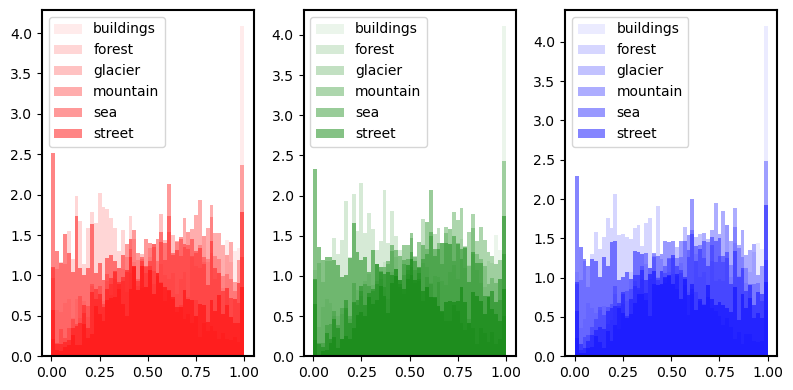

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))

for i, c in enumerate(["red", "green", "blue"]):
    ca = ax[i]
    for cls in range(6):
        cls_img = train_data[train_labels == cls]
        ca.hist(cls_img[..., i].flatten(), color=c, alpha=0.08*(cls+1), density=True, bins=50, zorder=-cls, label=labels[cls])
    ca.legend()

fig.tight_layout()
    

In [42]:
with open('../models/embedding_train.pickle', 'rb') as handle:
    train_feats = pickle.load(handle)

with open('../models/embedding_validation.pickle', 'rb') as handle:
    validation_feats = pickle.load(handle)


with open("../models/labels.pickle", "rb") as handle:
    # labels = {"train": train_labels, "validation": validation_labels, "categorical": cats}
    embed_labels = pickle.load(handle)

In [81]:
vals = []
for cls in range(6):
    feats = train_feats[embed_labels["train"] == cls]
    hist, bins = np.histogram(feats, bins=500)
    vals.append(hist)
vals = np.stack(vals)

dataframe = pd.DataFrame(data=vals.T, columns=embed_labels["categorical"])
    

<AxesSubplot: >

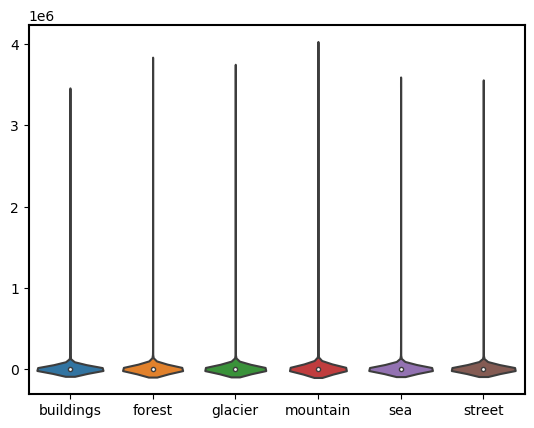

In [82]:
sns.violinplot(data=dataframe)